### Spyridon Mouselinos
### December 2019
### Assignment 3 Practical Data Science
***

In [1]:
### IMPORTS
import re
import pandas as pd
import sklearn
import numpy as np
import tweepy
import time
from twitter_config import config
import matplotlib.pyplot as plt
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
### We are going to use the Tweeter API so we put our config file alongside our notebook,
### our config file will be named twitter_config.py and will contain our auth keys.

In [3]:
def establish_connection(config):
    """Function to Establish Connection to Twitter Api """
    auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
    auth.set_access_token(config['access_token'], config['access_token_secret'])
    try:
        api = tweepy.API(auth)
    except:
        raise("Connection Not Established...")
    return api

In [4]:
api = establish_connection(config=config)

### Part 1

## Data Preparation

* Get the dataset from <https://www.clarin.si/repository/xmlui/handle/11356/1071>.

* You will use the `retweets.csv` file.

In [5]:
### We set as the data folder of our required files the relative to the notebook folder data_folder
data_folder = 'data_folder/'
data_location = data_folder + 'retweets.csv'
data = pd.read_csv(data_location)

* Keep only the records for which the language of the original tweet is in English.

In [6]:
### What options do we have?
data['lang'].unique()

array(['el', 'fr', 'en', 'de', 'pl', 'es', 'sk', 'it', 'sv', 'nl', 'da',
       'pt', 'cy', 'fi', 'ro', 'lt', 'sl', 'und', 'et', 'hr', 'bs', 'no',
       'in', 'hu', 'bg', 'lv', 'uk', 'tl', 'ht', 'ru', 'is', 'cs'],
      dtype=object)

In [7]:
### Ok let's keep the 'en' only tweets
data = data[data['lang'] == 'en']
data.reset_index(inplace=True,drop=True)

In [8]:
tweet_id_list = list(data['origTweetId'].values)

In [9]:
### Let's make a column to keep the tweet text
data['org_text'] = None

* Get the text of the *original tweet* and add it to the dataset as an extra column. Use the Tweeter API to get the text (e.g., with Tweepy). In order not to run into rate limits you can ask for multiple tweets with one call.

* Keep only the records for which you were able to download the tweet text.

In [10]:
def get_and_append_original_tweets(api, df, tweet_id_list, limit=100, sleep_time=10):
    """
        Let's calculate the number of iterations we will perform
        using the Tweepy API
    """
    n_iter = 1 + len(tweet_id_list) // limit
    if sleep_time !=0:
        print("Performing {} iterations ETA:{} seconds".format(n_iter, n_iter*sleep_time))
    
    """
        Iterate over a bunch of limit items
    """
    for i in range(0, n_iter):
        i_low = limit*i
        i_high = limit*(i+1)
        slice_ = tweet_id_list[i_low:i_high]
        tweets_retrieved = api.statuses_lookup(id_=slice_)
        for tweet in tweets_retrieved:
            df.loc[df['origTweetId'] == tweet.id,'org_text'] = tweet.text
        time.sleep(sleep_time)
    return df

In [11]:
data = get_and_append_original_tweets(api=api, df=data, tweet_id_list=tweet_id_list, limit=100, sleep_time=0)
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)

* Group the records by the European group of the MEP that posted the original tweet. If you see that there are groups with very few tweets (less than 50), drop them. 

In [13]:
kwargs_1 ={
    'x':'origMepGroupShort',
    'y':'org_text',
    'rot':90,
    'legend':None,
    'color':plt.cm.Paired(np.arange(len(data)))
}

kwargs_2 = {
    'xlabel':'European Group',
    'ylabel':'Number of Tweets'
}

In [14]:
grouped_data = data[['origMepGroupShort','org_text']].groupby('origMepGroupShort').agg('count').reset_index().sort_values(by='org_text')

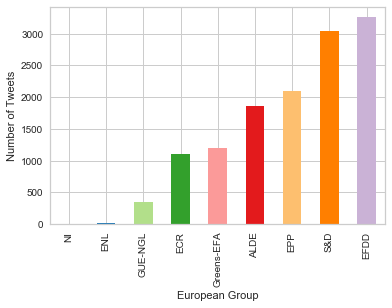

In [15]:
_ = grouped_data.plot.bar(**kwargs_1).set(**kwargs_2)

In [16]:
### We see that the first two groups need to be removed from our data
data = data[(data['origMepGroupShort'] != 'NI') & (data['origMepGroupShort'] != 'ENL')]
data.reset_index(inplace=True, drop=True)

### Part 2

## Tokenizing and Encoding

* The tweet texts must be converted to a format suitable for k-means, bag of word matrices or tf-idf matrices.

  * That means that you will need to use a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or a [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 
  
  * You may want to strip accents, and convert everything to lowercase. 
  
  * Use `min_df=10` and `max_df=0.50`.
  
  * Remove all English stopwords.
  

In [17]:
### Our Corpus is the total list of all the texts in the Dataframe

In [18]:
### Let's Remove the Links from the Text ###
data['word_list'] = data['org_text'].apply(lambda x: re.sub(r'http?://\S+', '', str(x)))
data['word_list'] = data['word_list'].apply(lambda x: re.sub(r'https?://\S+', '', str(x)))

### Let's create a column that has every word of each tweet stripped of (# and @).
data['word_list'] = data.word_list.str.findall(r'\w+')

### Now let's remove the words themselves ###
data['word_list'] = data['word_list'].apply(lambda x: [f for f in x if f not in ['http','https']])
### Now Let's cast them to lowercase and then create list that will act as our document_list / corpus
data['word_list'] = data.word_list.str.join(' ')
data['word_list'] = data.word_list.str.lower()

In [19]:
### We notice we have duplicate tweets that will distort the effect of min_df and max_df we may set afterwards, for that reason we should remove the duplicates and then proceed
corpus = list(data.drop_duplicates(subset=['word_list'], keep='first', inplace=False)['word_list'].values)

In [20]:
#### Transformers ####

In [21]:
def create_bow_transformer(data, corpus):
    bow_transformer = CountVectorizer(input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    token_pattern='(?u)\\b\\w\\w\\w+\\b',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=0.50,
    min_df=10)
    bow_transformer.fit(corpus)
    bow_encoded_data = bow_transformer.transform(data['word_list'].values)
    reverse_bow_dict = {bow_transformer.vocabulary_[k]:k for k in bow_transformer.vocabulary_.keys()}
    return bow_encoded_data, reverse_bow_dict

In [22]:
def create_tfidf_transformer(data, corpus):
    tfidf_transformer = TfidfVectorizer(input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    token_pattern='(?u)\\b\\w\\w\\w+\\b',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=0.50,
    min_df=10,
    norm='l2',
    use_idf=True,
    smooth_idf=True)
    tfidf_transformer.fit(corpus)
    tfidf_encoded_data = tfidf_transformer.transform(data['word_list'].values)
    reverse_tfidf_dict = {tfidf_transformer.vocabulary_[k]:k for k in tfidf_transformer.vocabulary_.keys()}
    return tfidf_encoded_data, reverse_tfidf_dict

* Use k-means to cluster the tweets based on their text.
* Use both the elbow method and the silhouette score to investigate the best number of clusters. Settle on the best number of clusters. 

## Clustering

In [23]:
def top_k(cluster_center, k=10, lexicon=None):
    if lexicon is None:
        print("Pass something to reverse engineer!\n")
        return
    
    cluster_idx = (-cluster_center).argsort()[:k]
    words_of_importance = [lexicon[f] for f in cluster_idx]
    return words_of_importance

In [24]:
def perform_clustering(data_to_cluster):
    kmeans = KMeans(random_state=1453)
    visualizer = KElbowVisualizer(kmeans, k=(2,15))
    visualizer.fit(data_to_cluster)
    visualizer.show()
    plt.figure(figsize=(20,  40))

    scores = {}
    for n_clusters in range(2, 12):
        plt.subplot(10, 2, n_clusters - 1)
        kmeans = KMeans(n_clusters, random_state=1453)
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
        visualizer.fit(data_to_cluster)
        scores[n_clusters] = visualizer.silhouette_score_
        plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')
    return

def inspect_clusters(data_to_cluster,reverse_dict,n_clusters):
    # Instantiate the clustering model and visualizer
    model = KMeans(n_clusters, random_state=1453)
    visualizer = InterclusterDistance(model,size=(1080, 720), legend_locstr='upper left')
    visualizer.fit(data_to_cluster)   
    _ = visualizer.show()        

    for i, cluster_center in enumerate(model.cluster_centers_):
        print("Cluster {} most important dimension indexes...".format(i))
        print(top_k(cluster_center, lexicon=reverse_dict))
        print()
    return

In [25]:
### FOR BOG DATA ###

In [26]:
bow_encoded_data, reverse_bow_dict = create_bow_transformer(data,corpus)

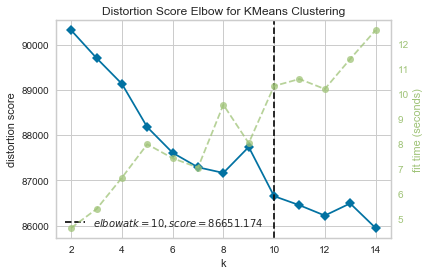

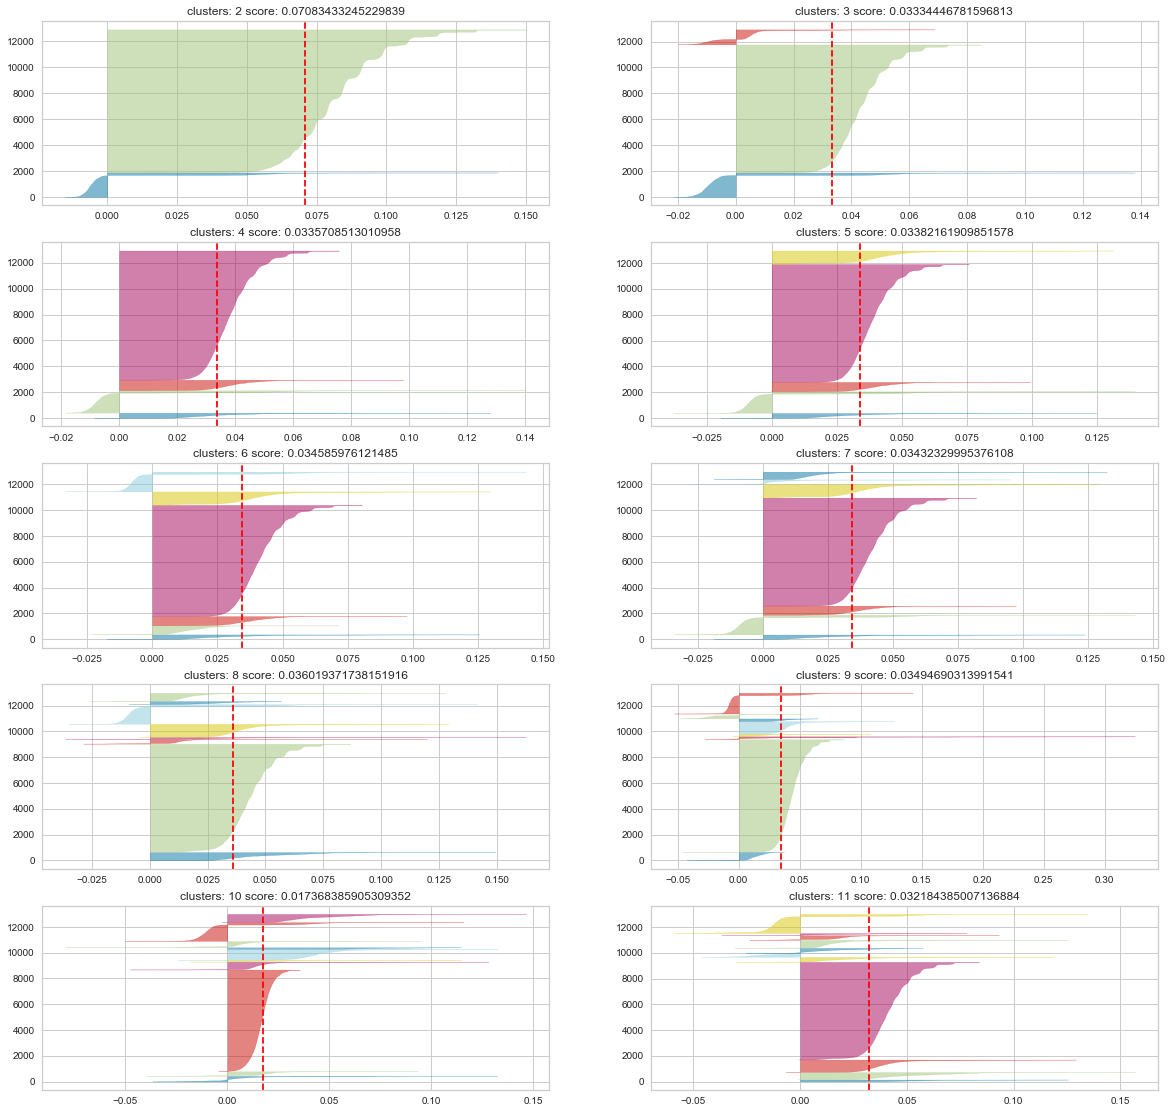

In [27]:
perform_clustering(data_to_cluster = bow_encoded_data)

In [28]:
### We will plot the clustering with the highest score n_clusters=8 as well as the n_clusters with the elbow method at n_clusters=11

In [29]:
### Lets's inspect clusters at 8 clusters

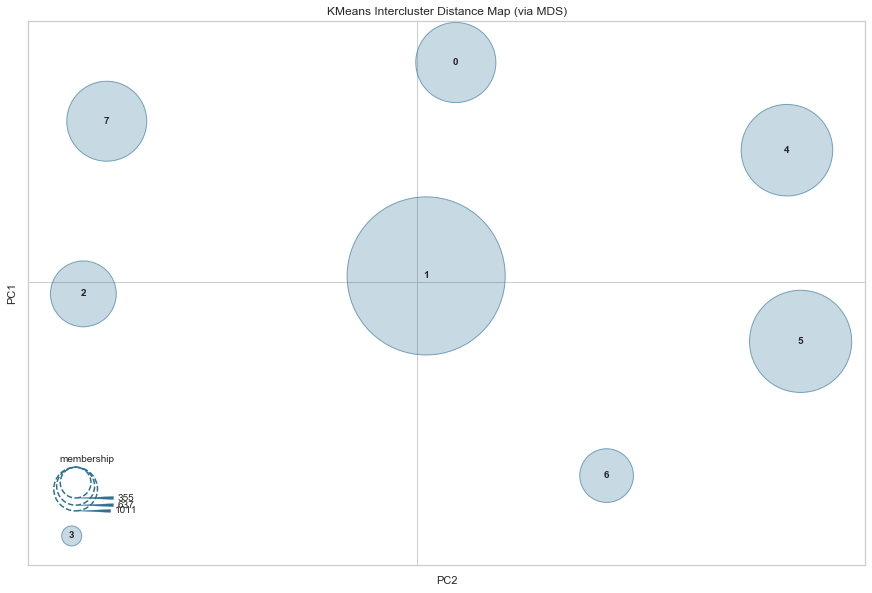

Cluster 0 most important dimension indexes...
['european', 'parliament', 'amp', 'union', 'today', 'commission', 'just', 'debate', 'eppgroup', 'ttip']

Cluster 1 most important dimension indexes...
['today', 'eppgroup', 'people', 'great', 'ttip', 'vote', 'meeting', 'labour', 'meps', 'support']

Cluster 2 most important dimension indexes...
['new', 'amp', 'today', 'eppgroup', 'year', 'ukip', 'european', 'good', 'people', 'great']

Cluster 3 most important dimension indexes...
['states', 'member', 'eppgroup', 'amp', 'need', 'tax', 'refugees', 'luxleaks', 'investment', 'junckereu']

Cluster 4 most important dimension indexes...
['ukip', 'vote', 'labour', 'today', 'party', 'nhs', 'people', 'amp', 'poll', 'policy']

Cluster 5 most important dimension indexes...
['amp', 'eppgroup', 'good', 'today', 'meeting', 'meps', 'ttip', 'vote', 'need', 'debate']

Cluster 6 most important dimension indexes...
['eurolabour', 'amp', 'meps', 'theprogressives', 'support', 'great', 'jude_kd', 'good', 'ttip', '

In [30]:
inspect_clusters(bow_encoded_data,reverse_dict=reverse_bow_dict, n_clusters=8)

In [31]:
### We can't make clear descisions about the context of the clusters. However, we can see that:
### Cluster 0 Theme: Commision / EppGroup
### Cluster 1 Theme: Labour party / EppGroup
### Cluster 2 Theme: EppGroup / Ukip party
### Cluster 3 Theme: Refugees / luxleaks( Luxemburg Leaks financial scandal)
### Cluster 4 Theme: Labour party / EppGroup
### Cluster 5 Theme: Eppgroup / Voting-Debates
### Cluster 6 Theme: Progressives/ European Labour Party
### Cluster 7 Theme: Greece / Refugees / Europe

In [32]:
### Lets's inspect clusters at 10 clusters

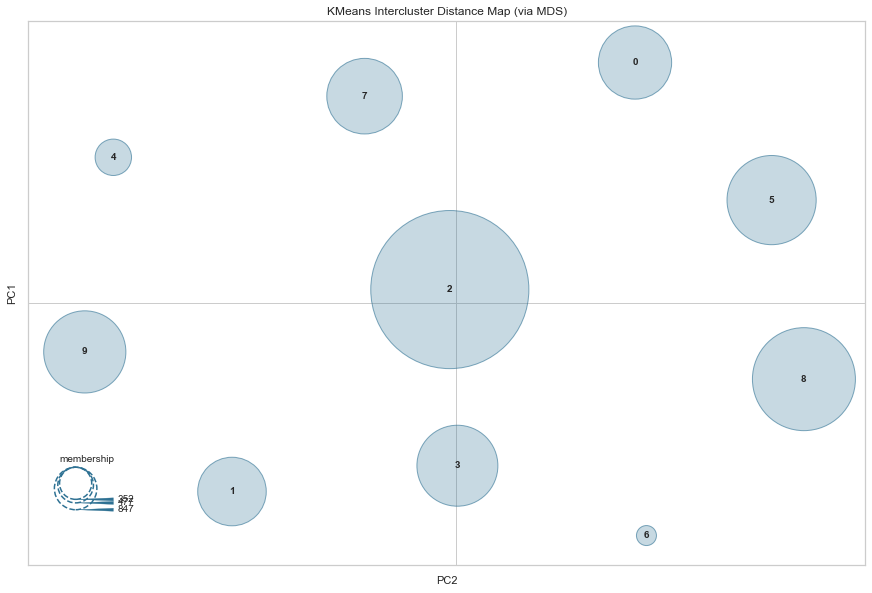

Cluster 0 most important dimension indexes...
['vote', 'ukip', 'ttip', 'amp', 'meps', 'labour', 'today', 'debate', 'votes', 'yes']

Cluster 1 most important dimension indexes...
['just', 'ukip', 'amp', 'heart', 'eppgroup', 'voted', 'public', 'debate', 'today', 'adopted']

Cluster 2 most important dimension indexes...
['today', 'eppgroup', 'great', 'meeting', 'meps', 'support', 'labour', 'europarl_en', 'ttip', 'new']

Cluster 3 most important dimension indexes...
['europe', 'amp', 'eppgroup', 'need', 'people', 'greece', 'change', 'today', 'refugees', 'migration']

Cluster 4 most important dimension indexes...
['news', 'good', 'great', 'eppgroup', 'amp', 'agreement', 'people', 'bbc', 'europe', 'citizens']

Cluster 5 most important dimension indexes...
['ukip', 'nhs', 'party', 'labour', 'today', 'amp', 'poll', 'policy', 'election', 'immigration']

Cluster 6 most important dimension indexes...
['thank', 'amp', 'support', 'work', 'eppgroup', 'great', 'year', 'congratulations', 'europe', 'gi

In [33]:
inspect_clusters(bow_encoded_data,reverse_dict=reverse_bow_dict, n_clusters=10)

In [34]:
### We can't make clear descisions about the context of the clusters. However, we can see that:
### Cluster 0 Theme: Labour party / Ukip party / Voting Debates
### Cluster 1 Theme: Ukip party / Voting Debates
### Cluster 2 Theme: EppGroup / Europarliament meeting
### Cluster 3 Theme: Greece / Refugees / Europe
### Cluster 4 Theme: EppGroup / BBC news
### Cluster 5 Theme: Labour party / Election / Immigration
### Cluster 6 Theme: Europe / Work 
### Cluster 7 Theme: Greece / Ukip Party 
### Cluster 8 Theme: Progressives/ European Labour Party
### Cluster 9 Theme: European Parliament / Commission 

In [35]:
#### Now for TF-IDF DATA

In [36]:
tfidf_encoded_data, reverse_tfidf_dict = create_tfidf_transformer(data,corpus)

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


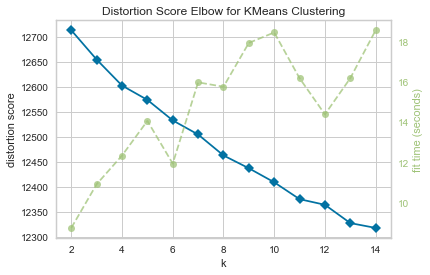

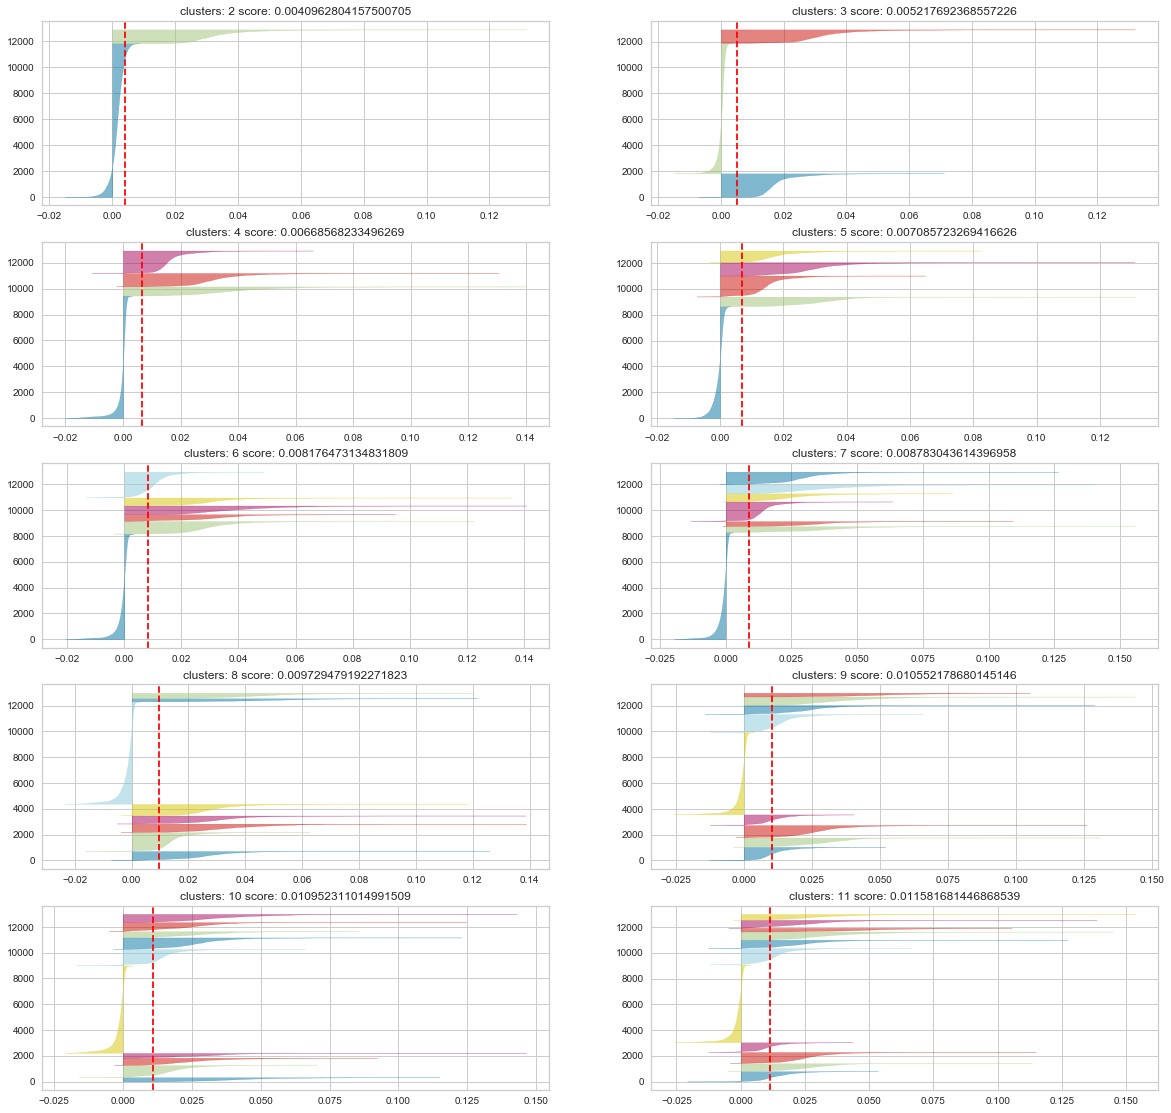

In [37]:
perform_clustering(data_to_cluster = tfidf_encoded_data)

In [38]:
### Let's inspect the clusters at 8

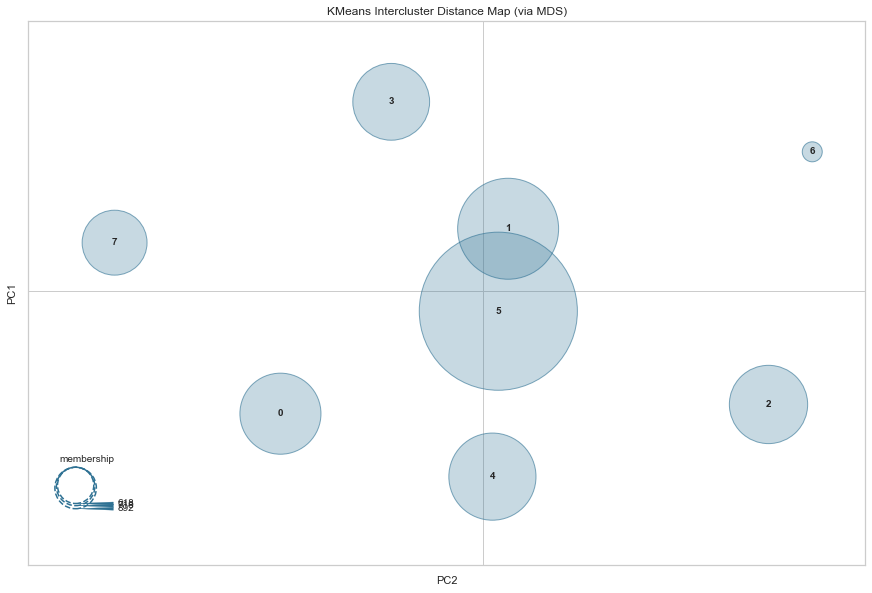

Cluster 0 most important dimension indexes...
['today', 'ukip', 'amp', 'meps', 'day', 'great', 'meeting', 'debate', 'people', 'support']

Cluster 1 most important dimension indexes...
['amp', 'eppgroup', 'good', 'meeting', 'meps', 'need', 'vote', 'theprogressives', 'people', 'energy']

Cluster 2 most important dimension indexes...
['european', 'parliament', 'union', 'amp', 'commission', 'just', 'today', 'eppgroup', 'debate', 'live']

Cluster 3 most important dimension indexes...
['europe', 'eppgroup', 'amp', 'need', 'people', 'change', 'greece', 'refugees', 'needs', 'says']

Cluster 4 most important dimension indexes...
['ukip', 'labour', 'party', 'vote', 'nhs', 'poll', 'election', 'lab', 'immigration', 'voters']

Cluster 5 most important dimension indexes...
['eppgroup', 'great', 'support', 'people', 'meeting', 'meps', 'labour', 'just', 'good', 'new']

Cluster 6 most important dimension indexes...
['britain', 'ukip', 'believe', 'people', 'referendum', 'leave', 'juncker', 'amp', 'briti

In [39]:
inspect_clusters(tfidf_encoded_data,reverse_dict=reverse_tfidf_dict, n_clusters=8)

In [40]:
### TFIDF doesnt change things much either at 8 clusters.
### We still can't make clear descisions about the context of the clusters. 
### However, we can see that:
### Cluster 0 Theme: Ukip party / Debate
### Cluster 1 Theme: EppGroup / Vote / Progressives
### Cluster 2 Theme: EppGroup / Commission / Debate
### Cluster 3 Theme: Greece / Refugees / Eppgroup
### Cluster 4 Theme: Ukip Party / Labour / Election / Immigration
### Cluster 5 Theme: Eppgroup / Labour Party
### Cluster 6 Theme: Brexit / Referendum / Ukip party
### Cluster 7 Theme: European Labour Party / Vote

In [41]:
### Let's inspect the clusters at 10

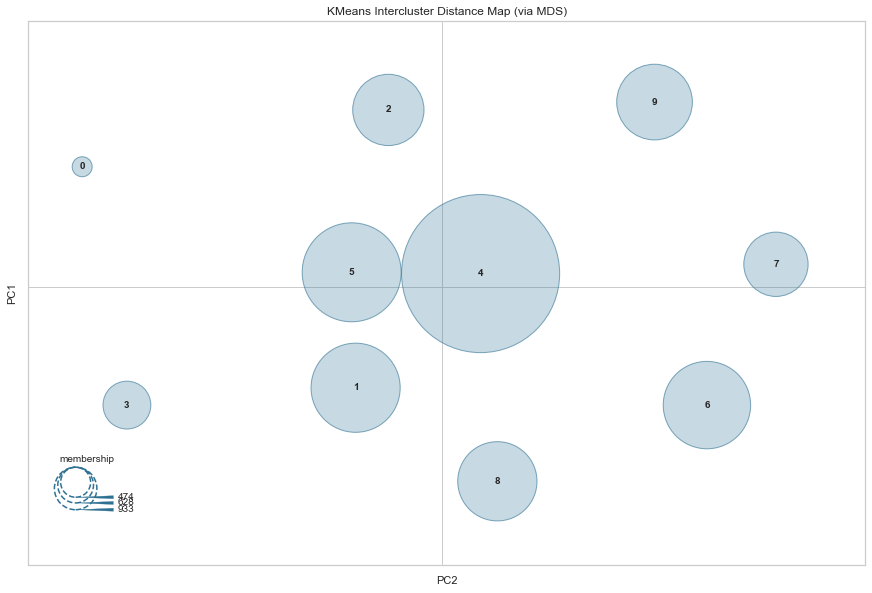

Cluster 0 most important dimension indexes...
['greece', 'tsipras', 'euro', 'greek', 'amp', 'eurozone', 'atsipras', 'europe', 'people', 'eppgroup']

Cluster 1 most important dimension indexes...
['eppgroup', 'europe', 'amp', 'epp', 'meeting', 'comilara', 'states', 'need', 'strongly', 'manfredweber']

Cluster 2 most important dimension indexes...
['ttip', 'vote', 'isds', 'meps', 'trade', 'amp', 'labour', 'debate', 'public', 'malmstromeu']

Cluster 3 most important dimension indexes...
['new', 'amp', 'year', 'eppgroup', 'today', 'ukip', 'eu_commission', 'rules', 'european', 'happy']

Cluster 4 most important dimension indexes...
['great', 'support', 'labour', 'meeting', 'cameron', 'meps', 'good', 'europarl_en', 'just', 'need']

Cluster 5 most important dimension indexes...
['amp', 'good', 'meps', 'meeting', 'need', 'theprogressives', 'energy', 'rights', 'great', 'mep']

Cluster 6 most important dimension indexes...
['ukip', 'nhs', 'labour', 'party', 'vote', 'poll', 'lab', 'immigration', 

In [42]:
inspect_clusters(tfidf_encoded_data,reverse_dict=reverse_tfidf_dict, n_clusters=10)

In [43]:
### TFIDF however makes much more sense at 10 clusters.
### We can see that:
### Cluster 0 Theme: Greece / Tsipras / Eurozone
### Cluster 1 Theme: Eppgroup / Meetings
### Cluster 2 Theme: Vote / Trade / Debate
### Cluster 3 Theme: Commission / Ukip party / Eppgroup
### Cluster 4 Theme: Labour / Cameron / Europarliament
### Cluster 5 Theme: The progressives / Meps Meetings
### Cluster 6 Theme: Immigration / Ukip party
### Cluster 7 Theme: Greece / Britain / Ukip party
### Cluster 8 Theme: Europarliament /  Meetings
### Cluster 9 Theme: Debate / Commission / European Parliament

## Classification

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [45]:
def show_results(clf, X_test, y_test):
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    return

In [46]:
### Get Training Data (X_Data) and Labels as integer categories (Y_Data)

In [47]:
X_data = data['word_list'].values
Y_data_original = data['origMepGroupShort'].astype('category')
Y_data = Y_data_original.cat.codes.values

In [48]:
# Split the dataset in two parts Train/Test at 65/35 ratio
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.35, random_state=1453)

***
### MultiNomial Bayes ###
***

In [49]:
### Lets make the Grid Search parameter space 

In [50]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'vect__token_pattern':['(?u)\\b\\w\\w+\\b','(?u)\\b\\w\\w\\w+\\b'],
              'vect__max_df':[0.4,0.5,0.6],
              'vect__min_df':[0.0,0.1],
              'clf__alpha': (0.2, 0.1, 0.05, 0.01, 0.001)
             }

In [51]:
### Let's build a GV Setting for Multinomial Naive Bayes

In [52]:
text_clf = Pipeline([('vect', CountVectorizer(strip_accents='unicode',stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_params_

{'clf__alpha': 0.01,
 'tfidf__use_idf': False,
 'vect__max_df': 0.4,
 'vect__min_df': 0.0,
 'vect__ngram_range': (1, 2),
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b'}

In [53]:
### Fit on full set without CV
best_MNB = gs_clf.best_estimator_
best_MNB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.4,
                                 max_features=None, min_df=0.0,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents='unicode',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('clf',
                 MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))],
         verbose=False)

In [54]:
#### Lets see the results on the Test Set
show_results(clf=best_MNB, X_test=X_test, y_test=y_test)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       642
           1       0.72      0.40      0.51       393
           2       0.77      0.92      0.84      1105
           3       0.70      0.74      0.72       722
           4       0.90      0.49      0.63       134
           5       0.73      0.52      0.60       426
           6       0.69      0.77      0.73      1096

    accuracy                           0.72      4518
   macro avg       0.74      0.64      0.67      4518
weighted avg       0.72      0.72      0.71      4518




***
###  Complement Naive Bayes ###
***

In [55]:
### Let's build a GV Setting for Complement Naive Bayes

In [56]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'vect__token_pattern':['(?u)\\b\\w\\w+\\b','(?u)\\b\\w\\w\\w+\\b'],
              'vect__max_df':[0.4,0.5,0.6],
              'vect__min_df':[0.0,0.1],
              'clf__alpha': (0.5, 0.4 ,0.3, 0.1)
             }

In [57]:
text_clf = Pipeline([('vect', CountVectorizer(strip_accents='unicode',stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', ComplementNB()),
                    ])
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_params_

{'clf__alpha': 0.3,
 'tfidf__use_idf': False,
 'vect__max_df': 0.4,
 'vect__min_df': 0.0,
 'vect__ngram_range': (1, 2),
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b'}

In [58]:
### Fit on full set without CV
best_CNB = gs_clf.best_estimator_
best_CNB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.4,
                                 max_features=None, min_df=0.0,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents='unicode',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('clf',
                 ComplementNB(alpha=0.3, class_prior=None, fit_prior=True,
                              norm=False))],
         verbose=Fal

In [59]:
#### Lets see the results on the Test Set
show_results(clf=best_CNB, X_test=X_test, y_test=y_test)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.68      0.65      0.66       642
           1       0.79      0.40      0.53       393
           2       0.73      0.93      0.82      1105
           3       0.70      0.78      0.73       722
           4       0.86      0.57      0.68       134
           5       0.75      0.51      0.61       426
           6       0.75      0.75      0.75      1096

    accuracy                           0.73      4518
   macro avg       0.75      0.66      0.69      4518
weighted avg       0.73      0.73      0.72      4518




***
### Stochastic Gradient Descend Classifier ###
***

In [60]:
### Let's build a GV Setting for SGDClassifier

In [61]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'vect__token_pattern':['(?u)\\b\\w\\w+\\b','(?u)\\b\\w\\w\\w+\\b'],
              'vect__max_df':[0.3,0.4,0.5],
              'vect__min_df':[0.0,0.1],
              'clf__alpha': (0.005,0.001),
             }

In [62]:
text_clf = Pipeline([('vect', CountVectorizer(strip_accents='unicode',stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(max_iter=1000,loss='hinge',penalty='l2',random_state=1453))
                    ])

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_params_

{'clf__alpha': 0.005,
 'tfidf__use_idf': True,
 'vect__max_df': 0.3,
 'vect__min_df': 0.0,
 'vect__ngram_range': (1, 2),
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b'}

In [63]:
### Fit on full set without CV
best_SGD = gs_clf.best_estimator_
best_SGD.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.3,
                                 max_features=None, min_df=0.0,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents='unicode',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                ('clf',
                 SGDClassifier(alpha=0.005, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [64]:
#### Lets see the results on the Test Set
show_results(clf=best_SGD, X_test=X_test, y_test=y_test)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.72      0.57      0.64       642
           1       0.83      0.34      0.48       393
           2       0.66      0.94      0.78      1105
           3       0.69      0.77      0.73       722
           4       0.91      0.46      0.61       134
           5       0.78      0.44      0.56       426
           6       0.68      0.73      0.70      1096

    accuracy                           0.69      4518
   macro avg       0.75      0.61      0.64      4518
weighted avg       0.71      0.69      0.68      4518




***
### Dummy Classifier ###
***

In [72]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [73]:
show_results(clf=dummy_clf, X_test=X_test, y_test=y_test)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.13      0.12      0.12       642
           1       0.09      0.09      0.09       393
           2       0.25      0.27      0.26      1105
           3       0.16      0.17      0.17       722
           4       0.02      0.02      0.02       134
           5       0.11      0.10      0.10       426
           6       0.25      0.25      0.25      1096

    accuracy                           0.19      4518
   macro avg       0.14      0.14      0.14      4518
weighted avg       0.19      0.19      0.19      4518




### We can see that the best solution is the Complement Naive Bayes Method achieving:
***
#### Precision = 73%
#### Recall = 73%
#### F1- Score = 72%
***
### Compared to the results of a simple Dummy Classifier:
#### Precision = 19%
#### Recall = 19%
#### F1- Score = 19%
***

***
### EXTRA ###
***
### Let's get our best estimator and try: Imbalanced Class Stabilization.

In [67]:
### From the plot in Question 1 we can see that not all of the parties have the same amount of tweets.
### That creates a rather imbalanced dataset that can easily corrupt the results of our experiments especially
### the "Accuracy" metric score.

### There are 2 ways to combat this problem in literature. 
### The first one is the undersampling of the majority classes that in our case will severely reduce our already
### small dataset.

### The second one is the over-sampling of the not-so-much represented classes. Thats the method we will follow.
### However, nothing comes at free. This method can create duplicate points that are extremely dummy and contain 
### zero information. For this reason it is advised to apply some noise to the data and create "Nearly" the original
### points. The technique we are going to use is called SMOTE.


### SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
### based on those that already exist. It works randomly picking a point from the minority class and computing 
### the k-nearest neighbors for this point. 
### The synthetic points are added between the chosen point and its neighbors.

### However, during Over-Sampling, we can accidentaly create points so close to the points of another class, that 
### would eventually make our classification task perform worse.
### That points are called Tomek links. Tomek links are pairs of very close instances,
### but of opposite classes. Removing the instances of the majority class of each pair increases 
### the space between the two classes, facilitating the classification process.


### We will need the imblearn library
### pip install -U imbalanced-learn

In [68]:
from imblearn.combine import SMOTETomek

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'vect__token_pattern':['(?u)\\b\\w\\w+\\b','(?u)\\b\\w\\w\\w+\\b'],
              'vect__max_df':[0.4,0.5],
              'vect__min_df':[0.0],
              'clf__alpha': (0.5, 0.4)
             }

In [ ]:
from imblearn.pipeline import Pipeline as IMP

In [ ]:
text_clf = IMP([('vect', CountVectorizer(strip_accents='unicode',stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('smote', SMOTETomek()),
                     ('clf', ComplementNB()),
                    ])
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=6, cv=3)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_params_

In [ ]:
### Fit on full set without CV
experiment_1_clf = gs_clf.best_estimator_
experiment_1_clf.fit(X_train, y_train)

In [ ]:
#### Lets see the results.
show_results(clf=experiment_1_clf, X_test=X_test, y_test=y_test)

In [ ]:
### The results are not better than our best classifier, 
### meaning we cant explain the low accuracy due to the misbalanced dataset